# SageMaker Debugger 

#### Prerequisites

In [1]:
#!python -m pip install smdebug
#!conda install -c conda-forge -y shap

#### 1. Imports 

In [2]:
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig, CollectionConfig
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from smdebug.trials import create_trial
import pandas as pd
import sagemaker
import logging
import boto3
import time
import shap
import os

In [3]:
logger = logging.getLogger('sagemaker')
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

In [4]:
logger.info('[Using SageMaker version: {}]'.format(sagemaker.__version__))

[Using SageMaker version: 2.18.0]


#### 2. Essentials

In [5]:
region = boto3.Session().region_name
role = get_execution_role()

BUCKET = 'sagemaker-demo-892313895307' # USE YOUR ACCOUNT ID OR INITIALS AS SUFFIX
PREFIX = 'xgboost-clf'

##### 2.1 Get XGBoost Container Image

In [6]:
container_uri = sagemaker.image_uris.retrieve(region=region, 
                                              framework='xgboost', 
                                              version='1.0-1', 
                                              image_scope='training',
                                              py_version='py3')

Defaulting to only supported image scope: cpu.


##### 2.2 Load Data and S3 Locations

In [7]:
feature_names = ['bmi', 'diastolic_bp_change', 'systolic_bp_change', 'respiratory_rate']
X_train = pd.read_csv('.././DATA/train/train.csv', names=feature_names)

In [8]:
X_train.head()

,bmi,diastolic_bp_change,systolic_bp_change,respiratory_rate
0,0.025774,0.000,0.000000,0.000000
1,0.501068,0.000,0.000000,0.006625
0,0.113537,0.475,0.219858,0.000000
0,0.040950,0.175,0.035461,0.000000
0,0.387375,0.050,0.085106,0.016479


In [9]:
train_set_location = 's3://{}/{}/train/'.format(BUCKET, PREFIX)
test_set_location = 's3://{}/{}/test/'.format(BUCKET, PREFIX)

In [10]:
train_set_pointer = TrainingInput(s3_data=train_set_location, content_type='csv')
test_set_pointer = TrainingInput(s3_data=test_set_location, content_type='csv')

### 3. Enable Debugger in Estimator

#### 3.1 Create Debugger Hook Configuration

In [11]:
s3_output_path = f's3://{BUCKET}/{PREFIX}/debug'
base_job_name = 'classifier-debug'
save_interval = 5
hyperparameters = {
    'objective': 'binary:logistic',
    'num_round': 100,
    'eta': 0.8,
    'max_depth': 3,
    'min_child_weight': 4
}

In [12]:
debugger_hook_config = DebuggerHookConfig(
        s3_output_path=s3_output_path,  # required
        collection_configs=[
            CollectionConfig(
                name='metrics',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
            CollectionConfig(
                name='feature_importance',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
            CollectionConfig(
                name='full_shap',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
            CollectionConfig(
                name='average_shap',
                parameters={
                    'save_interval': str(save_interval)
                }
            ),
        ],
    )

#### 3.2 Create Debugger Rules 

In [13]:
rules = [Rule.sagemaker(rule_configs.loss_not_decreasing(),
                        rule_parameters={'collection_names': 'metrics', 
                                         'num_steps': str(save_interval * 2)})]

#### 3.3 Create Estimator

In [14]:
xgboost_estimator = Estimator(role=role, 
                              base_job_name=base_job_name, 
                              instance_count=1, 
                              instance_type='ml.m5.xlarge', 
                              image_name=container_uri, 
                              hyperparameters=hyperparameters, 
                              max_run=1800,
                              image_uri=container_uri,
                              debugger_hook_config=debugger_hook_config,
                              rules=rules)

This is a fire and forget event. By setting wait=False, you submit the job to run in the background.
Amazon SageMaker starts one training job and release control to next cells in the notebook.
Follow this notebook to see status of the training job.

In [15]:

xgboost_estimator.fit(
    {'train': train_set_pointer, 
     'validation': test_set_pointer},
     wait=False
)

Defaulting to the only supported framework/algorithm version: latest.
Ignoring unnecessary instance type: None.
Creating training-job with name: classifier-debug-2020-12-08-04-27-20-912


As a result of the above command, Amazon SageMaker starts one training job and one rule job for you. The first one is the job that produces the tensors to be analyzed. The second one analyzes the tensors to check if train-error and validation-error are not decreasing at any point during training.

Check the status of the training job below. After your training job is started, Amazon SageMaker starts a rule-execution job to run the LossNotDecreasing rule.

The cell below will block till the training job is complete.

In [16]:
while True:
    job_name = xgboost_estimator.latest_training_job.name
    client = xgboost_estimator.sagemaker_session.sagemaker_client
    description = client.describe_training_job(TrainingJobName=job_name)
    training_job_status = description['TrainingJobStatus']
    print(training_job_status)
    rule_job_summary = xgboost_estimator.latest_training_job.rule_job_summary()
    rule_evaluation_status = rule_job_summary[0]['RuleEvaluationStatus']
    print('Training Job Status: {}, Rule Evaluation Status: {}'.format(training_job_status, rule_evaluation_status))
    
    if training_job_status in ['Completed', 'Failed']:
        break

    time.sleep(10)

InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Evaluation Status: InProgress
InProgress
Training Job Status: InProgress, Rule Eva

In [17]:
xgboost_estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'LossNotDecreasing',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:892313895307:processing-job/classifier-debug-2020-12-0-lossnotdecreasing-561102ac',
  'RuleEvaluationStatus': 'InProgress',
  'LastModifiedTime': datetime.datetime(2020, 12, 8, 4, 32, 49, 58000, tzinfo=tzlocal())}]

In [18]:
s3_output_path = xgboost_estimator.latest_job_debugger_artifacts_path()
trial = create_trial(s3_output_path)

[2020-12-08 04:33:00.568 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:12988 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-demo-892313895307/xgboost-clf/debug/classifier-debug-2020-12-08-04-27-20-912/debug-output


In [19]:
trial.tensor_names()

[2020-12-08 04:33:01.606 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:12988 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-12-08 04:33:02.628 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:12988 INFO trial.py:210] Loaded all steps


['average_shap/f0',
 'average_shap/f1',
 'average_shap/f2',
 'average_shap/f3',
 'feature_importance/cover/f0',
 'feature_importance/cover/f1',
 'feature_importance/cover/f2',
 'feature_importance/cover/f3',
 'feature_importance/gain/f0',
 'feature_importance/gain/f1',
 'feature_importance/gain/f2',
 'feature_importance/gain/f3',
 'feature_importance/total_cover/f0',
 'feature_importance/total_cover/f1',
 'feature_importance/total_cover/f2',
 'feature_importance/total_cover/f3',
 'feature_importance/total_gain/f0',
 'feature_importance/total_gain/f1',
 'feature_importance/total_gain/f2',
 'feature_importance/total_gain/f3',
 'feature_importance/weight/f0',
 'feature_importance/weight/f1',
 'feature_importance/weight/f2',
 'feature_importance/weight/f3',
 'full_shap/f0',
 'full_shap/f1',
 'full_shap/f2',
 'full_shap/f3',
 'train-error',
 'validation-error']

In [20]:
trial.tensor("average_shap/f1").values()

{0: array([-0.00041457], dtype=float32),
 5: array([-0.0084757], dtype=float32),
 10: array([-0.00880412], dtype=float32),
 15: array([-0.00984937], dtype=float32),
 20: array([-0.00518984], dtype=float32),
 25: array([-0.00565601], dtype=float32),
 30: array([-0.00627293], dtype=float32),
 35: array([-0.00658726], dtype=float32),
 40: array([-0.00659725], dtype=float32),
 45: array([-0.0070634], dtype=float32),
 50: array([-0.01171882], dtype=float32),
 55: array([-0.01171882], dtype=float32),
 60: array([-0.0152334], dtype=float32),
 65: array([-0.01733271], dtype=float32),
 70: array([-0.02098005], dtype=float32),
 75: array([-0.02199874], dtype=float32),
 80: array([-0.02713667], dtype=float32),
 85: array([-0.02781285], dtype=float32),
 90: array([-0.02665937], dtype=float32),
 95: array([-0.02309296], dtype=float32)}

In [21]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def plot_collection(trial, collection_name, regex='.*', figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and 
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = sorted(trial.collection(collection_name).tensor_names)
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=tensor_name)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Iteration')

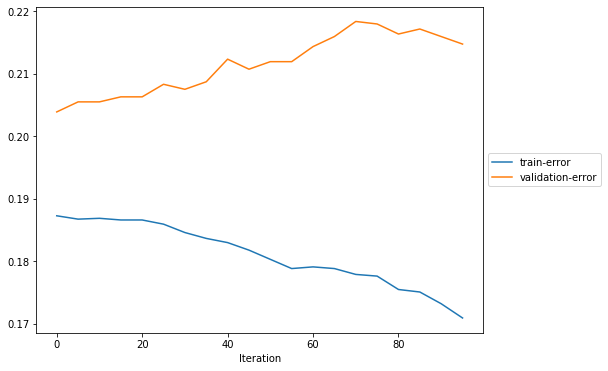

In [22]:
plot_collection(trial, "metrics")

In [23]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight", "gain", "cover", "total_gain", "total_cover"]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(
            f"{importance_type} is not one of the supported importance types.")
    plot_collection(
        trial,
        "feature_importance",
        regex=f"feature_importance/{importance_type}/.*")

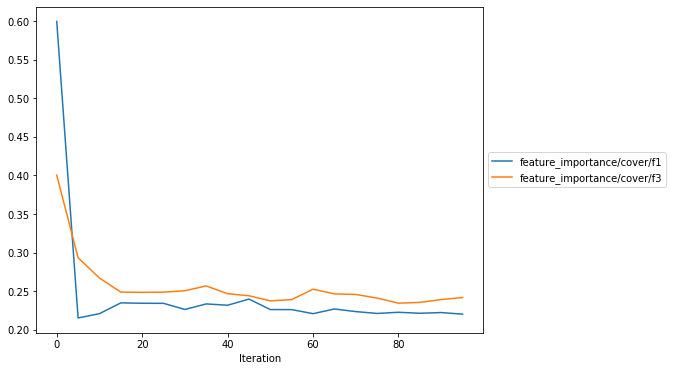

In [24]:
plot_feature_importance(trial, importance_type="cover")

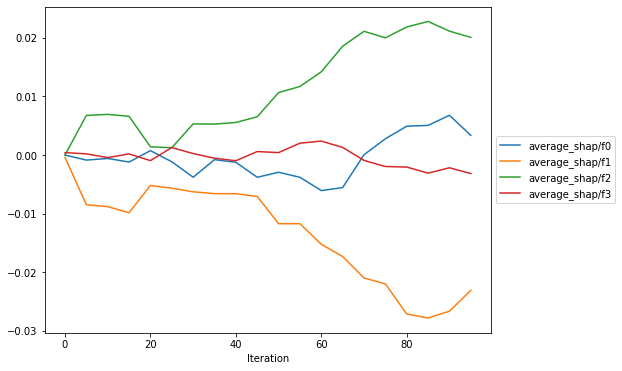

In [25]:
plot_collection(trial, "average_shap")

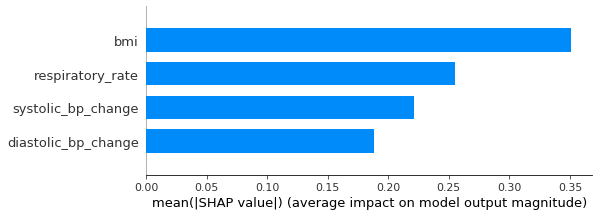

In [26]:
shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type='bar', feature_names=feature_names)

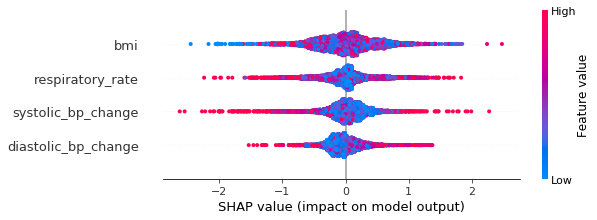

In [27]:
shap.summary_plot(shap_no_base, X_train)

In [32]:
shap.initjs()

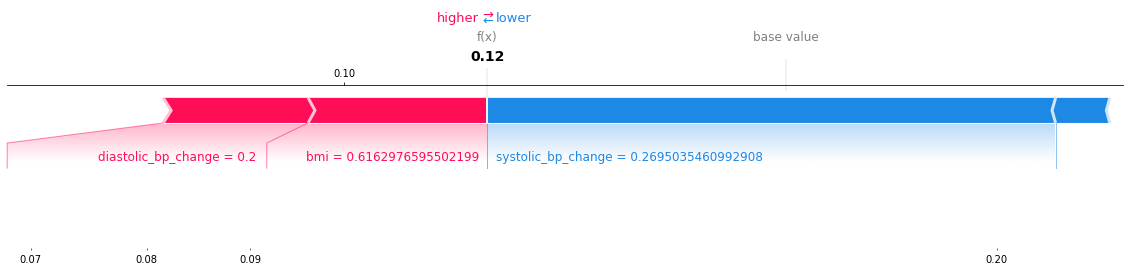

In [33]:
shap.force_plot(shap_base_value, shap_no_base[100, :],
                X_train.iloc[100, :], link="logit", matplotlib=True)

In [34]:

import numpy as np
N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

In [35]:
shap.force_plot(shap_base_value,
                shap_no_base[sampled_indices, :],
                X_train.iloc[sampled_indices, :],
                link='logit')